# Figure 1

In [1]:
# Doing an initial figure for the vibes. I'll update it as I get more info
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.coordinates import SkyCoord

In [2]:
plt.rcParams['font.family'] = 'sans-serif' 
plt.style.use('default')
#specifies arial as the preferred font for plots
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['axes.titlesize'] = 14  # font size for plot titles
plt.rcParams['axes.labelsize'] = 12  # font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 10 # font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 10 # font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 10 # font size for legend
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10

In [3]:
filename='astraAllStarASPCAP-0.6.0.fits/astraAllStarASPCAP-0.6.0.fits'
tb = fits.open(filename)
header=tb[2].header
data = tb[2].data 

In [4]:
mask_gaia = (data['zgr_plx']>0)

# use skycoord to input information, correct units
c = SkyCoord(ra=data['ra'][mask_gaia]*u.deg, dec=data['dec'][mask_gaia]*u.deg, 
             distance=(data['r_med_geo'][mask_gaia])*u.pc,
             pm_ra_cosdec=data['pmra'][mask_gaia]*u.mas/u.yr, 
             pm_dec=data['pmde'][mask_gaia]*u.mas/u.yr,
            radial_velocity=data['v_rad'][mask_gaia]*u.km/u.s) 

# transform to galactocentric coordinate
# the assumed values are from Schonrich et al 2010, and from Gravity collab 2022
galcen = c.transform_to(coord.Galactocentric(galcen_v_sun=[8, 254, 8] * u.km / u.s, galcen_distance=8.275 * u.kpc))

In [5]:
x = galcen.x.value
y = galcen.y.value
z = galcen.z.value

vx = galcen.v_x.value
vy = galcen.v_y.value
vz = galcen.v_z.value

#galactocentric radius (either in the disk-R or distance from the galactic center)
R = np.sqrt(x**2+y**2)
rgal = np.sqrt(x**2+y**2+z**2)

In [6]:
data_masked=data[mask_gaia]

In [7]:
# Age option 1 TESS data Theodoridis et al. 2025
#Reading in the table, making sure all the tables have a column named Age in Gyr
# and that every star in the table has an Age
tessraw = Table.read("Merged_Ages_TABLE2_ (2).csv", format="ascii")
#this one has an age column in Gyr already so we're just going to rename it Age
tessraw['Final_age'].name='Age'
hasagetess=np.where((tessraw['Age']==tessraw['Age']) & (tessraw['Age']>0.1) &(tessraw['Flag']==0))
tess=tessraw[hasagetess]

In [8]:
apokasc2raw = Table.read("Pinsonneault2018.txt", format="ascii.cds")
apokasc2raw['Age']=(10**np.array(apokasc2raw['LogAge'])/1000.)
hasagea2=np.where((apokasc2raw['Age']==apokasc2raw['Age']) & (apokasc2raw['Age']>0.1))
apokasc2=apokasc2raw[hasagea2]

In [9]:
apokasc3raw= Table.read("Pinsonneault2025.txt", format="ascii.cds")
#in this case there were two age columns, one for Red Clump and one for Red Giant Branch so we combine them
ageRC=np.array(apokasc3raw['AgeRC']*(apokasc3raw['EvolState']=='RC'))
rcnans=np.isnan(ageRC) #removing nans from this version of the table.
ageRC[rcnans]=0
ageRGB=np.array(apokasc3raw['AgeRGB']*(apokasc3raw['EvolState']=='RGB'))
rgbnans=np.isnan(ageRGB) #removing nans from this version of the table.
ageRGB[rgbnans]=0
apokasc3raw['Age']=(ageRC+ageRGB)

hasagea3=np.where((apokasc3raw['Age']==apokasc3raw['Age']) & (apokasc3raw['Age']>0.1))
apokasc3=apokasc3raw[hasagea3]

In [10]:
apok2raw = Table.read("Warfield2024.txt", format="ascii.cds")
#this one has an age column in Gyr already so we're just going to rename it Age
hasageapok2=np.where((apok2raw['Age']==apok2raw['Age']) & (apok2raw['Age']>0.1))
apok2=apok2raw[hasageapok2]

In [11]:
filename='GC_members_VAC-v1_1.fits'
tb_gc = fits.open(filename)
header_gc=tb_gc[0].header
data_gc = tb_gc[1].data

In [12]:
filename='occam_member-DR19.fits'
tb_oc = fits.open(filename)
header_oc=tb_oc[0].header
data_oc = tb_oc[1].data

In [13]:
filename='StarFlow_summary_v1_0_0.fits'
tb_sm_sample = fits.open(filename)
header_sm_sample=tb_sm_sample[0].header
data_sm_sample = tb_sm_sample[1].data

In [14]:
#APOKASC-2
intersect1, ind_d1, ind_a1 = np.intersect1d(data_masked['sdss4_apogee_id'],apokasc2['2MASS'], return_indices=True) 
#APOKASC-3
intersect2, ind_d2, ind_a2 = np.intersect1d(data_masked['gaia_dr3_source_id'],apokasc3['GaiaDR3'], return_indices=True) 
#APOK2
intersect3, ind_d3, ind_a3 = np.intersect1d(data_masked['sdss4_apogee_id'],apok2['APOGEE'], return_indices=True) 
#TESS
intersect4, ind_d4, ind_a4 = np.intersect1d(data_masked['tic_v8_id'],tess['TIC'], return_indices=True)
# Open Clusters
intersect5, ind_d5, ind_a5 = np.intersect1d(data_masked['sdss_id'],data_oc['SDSS_ID'], return_indices=True)
# Stone-Martinez
intersect6, ind_d6, ind_a6 = np.intersect1d(data_masked['sdss4_apogee_id'],data_sm_sample['sdss4_apogee_id'], return_indices=True) 
#Globbular Clusters
intersect7, ind_d7, ind_a7 = np.intersect1d(data_masked['sdss4_apogee_id'],data_gc['APOGEE_ID'], return_indices=True)

In [15]:
data_apokasc2 = data_masked[ind_d1]
data_apokasc3 = data_masked[ind_d2]
data_apok2 = data_masked[ind_d3]
data_tess = data_masked[ind_d4]
data_oc = data_masked[ind_d5]
data_gc = data_masked[ind_d7]
data_sm_sample = data_masked[ind_d6]

In [16]:
no_flags_apokasc2 = np.where((data_apokasc2['flag_bad'] == False))
no_flags_apokasc3 = np.where((data_apokasc3['flag_bad'] == False))
no_flags_apok2 = np.where((data_apok2['flag_bad'] == False))
no_flags_tess = np.where((data_tess['flag_bad'] == False))
no_flags_oc = np.where((data_oc['flag_bad'] == False))
no_flags_gc = np.where((data_gc['flag_bad'] == False))
no_flags_sm = np.where((data_sm_sample['flag_bad'] == False))

In [17]:
data_apokasc2 = data_apokasc2[no_flags_apokasc2]
data_apokasc3 = data_apokasc3[no_flags_apokasc3]
data_apok2 = data_apok2[no_flags_apok2]
data_tess = data_tess[no_flags_tess]
data_oc = data_oc[no_flags_oc]
data_gc = data_gc[no_flags_gc]
data_sm_sample = data_sm_sample[no_flags_sm]

In [18]:
min_metallicity = -2
max_metallicity = 0.6
good_teffmin, good_teffmax = 3700 , 5300
good_loggmin, good_loggmax = 0.9, 3.3

In [19]:
apokasc2_good_sample = np.where((data_apokasc2['teff'] > good_teffmin) & (data_apokasc2['teff'] < good_teffmax) & (data_apokasc2['logg'] > good_loggmin) & (data_apokasc2['logg'] < good_loggmax)
                                & (data_apokasc2['m_h_atm'] > min_metallicity) & (data_apokasc2['m_h_atm'] < max_metallicity))
apokasc3_good_sample = np.where((data_apokasc3['teff'] > good_teffmin) & (data_apokasc3['teff'] < good_teffmax) & (data_apokasc3['logg'] > good_loggmin) & (data_apokasc3['logg'] < good_loggmax) 
                                & (data_apokasc3['m_h_atm'] > min_metallicity) & (data_apokasc3['m_h_atm'] < max_metallicity))
apok2_good_sample = np.where((data_apok2['teff'] > good_teffmin) & (data_apok2['teff'] < good_teffmax) &  (data_apok2['logg'] > good_loggmin) & (data_apok2['logg'] < good_loggmax)
                                & (data_apok2['m_h_atm'] > min_metallicity) & (data_apok2['m_h_atm'] < max_metallicity))
tess_good_sample = np.where((data_tess['teff'] > good_teffmin) & (data_tess['teff'] < good_teffmax) & (data_tess['logg'] > good_loggmin) & (data_tess['logg'] < good_loggmax)
                                & (data_tess['m_h_atm'] > min_metallicity) & (data_tess['m_h_atm'] < max_metallicity))
gc_good_sample = np.where((data_gc['teff'] > good_teffmin) & (data_gc['teff'] < good_teffmax) & (data_gc['logg'] > good_loggmin) & (data_gc['logg'] < good_loggmax)
                                & (data_gc['m_h_atm'] > min_metallicity) & (data_gc['m_h_atm'] < max_metallicity))
oc_good_sample = np.where((data_oc['teff'] > good_teffmin) & (data_oc['teff'] < good_teffmax) & (data_oc['logg'] > good_loggmin) & (data_oc['logg'] < good_loggmax)
                                & (data_oc['m_h_atm'] > min_metallicity) & (data_oc['m_h_atm'] < max_metallicity))
sm_good_sample = np.where((data_sm_sample['teff'] > good_teffmin) & (data_sm_sample['teff'] < good_teffmax) & (data_sm_sample['logg'] > good_loggmin) & (data_sm_sample['logg'] < good_loggmax)
                                & (data_sm_sample['m_h_atm'] > min_metallicity) & (data_sm_sample['m_h_atm'] < max_metallicity))

In [20]:
data_apokasc2_good = data_apokasc2[apokasc2_good_sample]
data_apokasc3_good = data_apokasc3[apokasc3_good_sample]
data_apok2_good = data_apok2[apok2_good_sample]
data_tess_good = data_tess[tess_good_sample]
data_gc_good = data_gc[gc_good_sample]
data_oc_good = data_oc[oc_good_sample]
data_sm_sample_good = data_sm_sample[sm_good_sample]

Text(0.5, 0.01, 'Teff [K]')

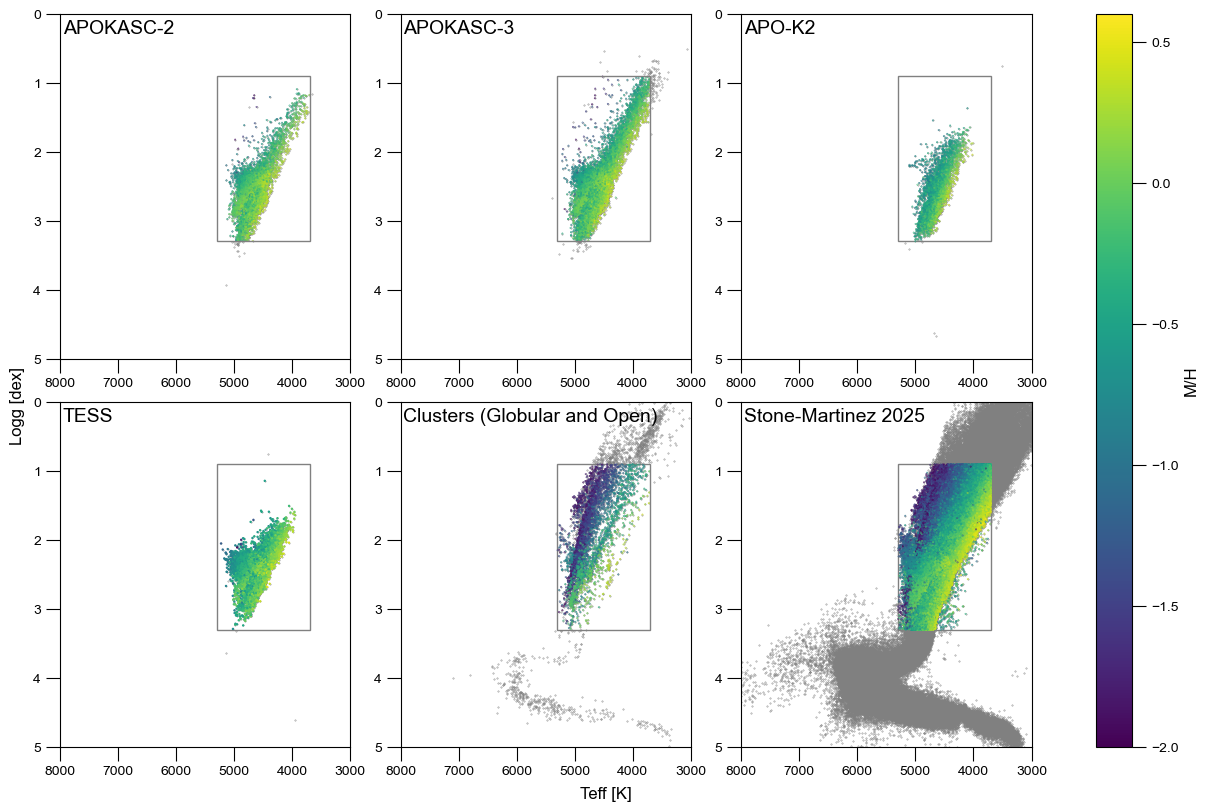

In [21]:
square_apokasc2 = plt.Rectangle((good_teffmin, good_loggmin), 
                                    good_teffmax - good_teffmin, good_loggmax - good_loggmin,
                                    edgecolor = 'grey', linestyle = '-', fill=False)
square_apokasc3 = plt.Rectangle((good_teffmin, good_loggmin), 
                                    good_teffmax - good_teffmin, good_loggmax - good_loggmin,
                                    edgecolor = 'grey', linestyle = '-', fill=False)
square_apok2 = plt.Rectangle((good_teffmin, good_loggmin), 
                                    good_teffmax - good_teffmin, good_loggmax - good_loggmin,
                                    edgecolor = 'grey', linestyle = '-', fill=False)
square_tess = plt.Rectangle((good_teffmin, good_loggmin), 
                                    good_teffmax - good_teffmin, good_loggmax - good_loggmin,
                                    edgecolor = 'grey', linestyle = '-', fill=False)
square_gc = plt.Rectangle((good_teffmin, good_loggmin), 
                                    good_teffmax - good_teffmin, good_loggmax - good_loggmin,
                                    edgecolor = 'grey', linestyle = '-', fill=False)
square_sm = plt.Rectangle((good_teffmin, good_loggmin), 
                                    good_teffmax - good_teffmin, good_loggmax - good_loggmin,
                                    edgecolor = 'grey', linestyle = '-', fill=False)


vmin = min_metallicity
vmax = max_metallicity

fig = plt.figure(figsize= (12,8), layout='constrained')
sps = fig.subplots(2,3)
sps[0,0].scatter(data_apokasc2['teff'], data_apokasc2['logg'], color='gray', s=0.1)
sps[0,0].scatter(data_apokasc2_good['teff'], data_apokasc2_good['logg'], c=data_apokasc2_good['m_h_atm'], vmin=vmin, vmax=vmax, s=0.1)
sps[0,0].add_patch(square_apokasc2)
sps[0,0].set_title('APOKASC-2', y=0.92, x=0.01, ha='left')
sps[0,0].axis([8000,3000,5,0])
sps[0,1].scatter(data_apokasc3['teff'], data_apokasc3['logg'], color='gray', s=0.1)
sps[0,1].scatter(data_apokasc3_good['teff'], data_apokasc3_good['logg'], c=data_apokasc3_good['m_h_atm'],  vmin=vmin, vmax=vmax, s=0.1)
sps[0,1].add_patch(square_apokasc3)
sps[0,1].set_title('APOKASC-3', y=0.92, x=0.01, ha='left')
sps[0,1].axis([8000,3000,5,0])
sps[0,2].scatter(data_apok2['teff'], data_apok2['logg'], color='gray', s=0.1)
sps[0,2].add_patch(square_apok2)
im=sps[0,2].scatter(data_apok2_good['teff'], data_apok2_good['logg'], c=data_apok2_good['m_h_atm'],  vmin=vmin, vmax=vmax, s=0.1)
sps[0,2].set_title('APO-K2', y=0.92, x=0.01, ha='left')
sps[0,2].axis([8000,3000,5,0])
sps[1,0].scatter(data_tess['teff'], data_tess['logg'], color='gray', s=0.1)
sps[1,0].add_patch(square_tess)
sps[1,0].scatter(data_tess_good['teff'], data_tess_good['logg'], c=data_tess_good['m_h_atm'], vmin=vmin, vmax=vmax, s=0.5)
sps[1,0].axis([8000,3000,5,0])
sps[1,0].set_title('TESS', y=0.92, x=0.01, ha='left')
sps[1,1].scatter(data_gc['teff'], data_gc['logg'], color='gray', s=0.1)
sps[1,1].scatter(data_oc['teff'], data_oc['logg'], color='gray', s=0.1)
sps[1,1].add_patch(square_gc)
sps[1,1].scatter(data_gc_good['teff'], data_gc_good['logg'], c=data_gc_good['m_h_atm'],  vmin=vmin, vmax=vmax, s=0.1)
sps[1,1].scatter(data_oc_good['teff'], data_oc_good['logg'], c=data_oc_good['m_h_atm'],  vmin=vmin, vmax=vmax, s=0.1)
sps[1,1].set_title('Clusters (Globular and Open)', y=0.92, x=0.01, ha='left')
sps[1,1].axis([8000,3000,5,0])
sps[1,2].scatter(data_sm_sample['teff'], data_sm_sample['logg'], color='gray', s=0.1)
sps[1,2].add_patch(square_sm)
sps[1,2].scatter(data_sm_sample_good['teff'], data_sm_sample_good['logg'], c=data_sm_sample_good['m_h_atm'],  vmin=vmin, vmax=vmax, s=0.1)
sps[1,2].set_title('Stone-Martinez 2025', y=0.92, x=0.01, ha='left')
sps[1,2].axis([8000,3000,5,0])
fig.colorbar(im, ax=sps, location='right', label='M/H')
fig.supylabel('Logg [dex]')
fig.supxlabel('Teff [K]')

In [24]:
apokasc3

KIC,EvolState,ESSource,CatTab,SeisSource,SpecSource,NNumax,NDNu,Nquar,Numax,e_Numax,DNu,e_DNu,FDNu,e_FDNu,FNumax,Mass,e_Mass,Radius,e_Radius,logg-Seis,e_logg-Seis,Teff,e_Teff,logg-Spec,e_logg-Spec,[Fe/H],e_[Fe/H],[a/Fe],e_[a/Fe],[C/Fe],e_[C/Fe],[N/Fe],e_[N/Fe],InvRGaia,e_InvRGaia,AgeCat,AgeRGB,E_AgeRGB,e_AgeRGB,AgeRC,E_AgeRC,e_AgeRC,vsini,alphaCat,GaiaDR3,2MASS,Age
,,,,,,,,,uHz,uHz,uHz,uHz,,,,solMass,solMass,Rsun,Rsun,dex(cm / s2),dex(cm / s2),K,K,dex(cm / s2),dex(cm / s2),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),,,,Gyr,Gyr,Gyr,Gyr,Gyr,Gyr,km / s,,,,
int64,str7,str4,str8,str4,str4,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,str5,int64,str23,float64
893214,RGB,Seis,Gold,WAvg,DR17,8,5,15,40.5841,0.2874,4.3254,0.0289,1.0277,0.005,0.9976,1.4404,0.0602,11.0014,0.2055,2.5146,0.0042,4718.9233,44.7811,2.4559,0.058,-0.2617,0.058,0.0815,0.022,-0.0626,0.0135,0.2483,0.0164,0.082389,0.002866,RGB,2.8815,0.298,-0.2639,2.8815,0.298,-0.2639,0.0,Apoor,2050237616959273728,2MASS J19245967+3638183,2.8815
1026180,RC,Spec,Gold,WAvg,DR17,8,5,4,35.6089,0.2338,3.9208,0.0265,0.9972,0.005,0.9936,1.5334,0.0633,12.2361,0.2278,2.4512,0.0039,4576.1016,40.5161,2.4066,0.058,0.2741,0.058,0.0215,0.022,0.0568,0.0084,0.3647,0.0107,0.085599,0.002161,RC,--,--,--,3.1325,0.2754,-0.1905,0.0,Apoor,2050237174589477888,2MASS J19241923+3645378,3.1325
1026309,RGB,Seis,Silver,WAvg,DR17,8,4,18,16.6974,0.5675,1.9432,0.0805,1.0072,0.005,1.0205,2.642,0.518,23.2678,2.0993,2.1176,0.0148,4479.2246,39.7068,2.2388,0.058,0.1609,0.058,-0.0295,0.022,-0.0823,0.0088,0.2913,0.011,0.047943,0.001239,RGB_AGB,0.5842,0.1481,-0.109,0.7082,0.1832,-0.1405,0.0,Apoor,2050236934071312384,2MASS J19242636+3643594,0.5842
1026452,RC,Seis,Gold,WAvg,DR17,8,5,18,34.3652,0.2256,3.9749,0.0268,0.9953,0.005,0.9936,1.4618,0.0599,11.9485,0.2215,2.451,0.0044,4910.6035,53.0693,2.4907,0.058,-0.2652,0.058,0.0658,0.022,0.0005,0.0189,0.1605,0.0222,0.075937,0.003795,RC,--,--,--,2.6495,0.2319,-0.1919,0.0,Apoor,2050243050104808960,2MASS J19243452+3647244,2.6495
1027110,RGB,Seis,Silver,WAvg,DR17,8,4,18,6.5198,0.1616,1.1613,0.044,1.0511,0.005,1.0535,1.0367,0.1769,23.337,1.8791,1.6949,0.011,4194.4375,37.9582,1.7495,0.058,-0.3017,0.058,0.2615,0.022,0.1451,0.0109,0.1366,0.0131,0.040245,0.001509,RGB_AGB,9.0694,8.0551,-3.8133,7.2088,4.6171,-2.3475,0.0,Arich,2050239201814200192,2MASS J19250937+3644599,9.0694
1027337,RGB,Seis,Gold,WAvg,DR17,9,6,18,74.3689,0.4491,6.9661,0.0418,1.0282,0.005,0.9959,1.2676,0.0489,7.6702,0.133,2.7732,0.0038,4621.996,41.3674,2.7836,0.058,0.2081,0.058,0.0354,0.022,0.062,0.009,0.2898,0.0115,0.123008,0.0033,RGB,5.8519,0.5953,-0.5247,5.8519,0.5953,-0.5247,0.0,Apoor,2050240782362231552,2MASS J19252021+3647118,5.8519
1027707,RGB,Seis,Silver,WAvg,DR17,6,3,18,3.0206,0.0885,0.5593,0.0309,1.0265,0.005,1.0663,2.0033,0.4792,48.0566,5.5208,1.3484,0.0129,3961.365,35.9864,1.4062,0.058,0.1105,0.058,0.0356,0.022,0.0455,0.0079,0.1751,0.0094,0.018104,0.001509,RGB_AGB,1.3052,0.6198,-0.3779,1.5494,0.4593,-0.4138,0.0,Apoor,2050240129527252096,2MASS J19253846+3646103,1.3052
1160655,RGB,Seis,Silver,WAvg,DR17,5,2,18,1.5726,0.0502,0.3698,0.024,1.0608,0.005,1.0525,1.1903,0.3305,52.0838,6.9807,1.058,0.0139,3837.788,33.9314,0.9088,0.058,-0.1446,0.058,0.1098,0.022,0.0582,0.0089,0.2023,0.0105,0.018767,0.001236,RGB_AGB,5.7073,8.7454,-2.777,5.013,5.3362,-2.0267,0.0,Arich,2050252395953454464,2MASS J19232193+3650379,5.7073
